<a href="https://colab.research.google.com/github/zrd123/my_colab/blob/master/code/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 图像卷积

In [ ]:
!pip install d2l==0.17.6

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

def corr2d(X, K):
    """计算二维互相关运算"""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [ ]:
# 卷积层
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [ ]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [ ]:
K = torch.tensor([[1.0, -1.0]])
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [ ]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

## 学习卷积核

In [ ]:
# 构造一个二维卷积层，它具有1个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2d(1,1, kernel_size=(1, 2), bias=False)

# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # 学习率

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # 迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i+1}, loss {l.sum():.3f}')

epoch 2, loss 10.862
epoch 4, loss 1.996
epoch 6, loss 0.406
epoch 8, loss 0.097
epoch 10, loss 0.028


In [ ]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9687, -0.9981]])

# 填充和步幅

In [ ]:
import torch
from torch import nn


# 为了方便起见，我们定义了一个计算卷积层的函数。
# 此函数初始化卷积层权重，并对输入和输出提高和缩减相应的维数
def comp_conv2d(conv2d, X):
    # 这里的（1，1）表示批量大小和通道数都是1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # 省略前两个维度：批量大小和通道
    return Y.reshape(Y.shape[2:])

# 请注意，这里每边都填充了1行或1列，因此总共添加了2行或2列
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [ ]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [ ]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride = 2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [ ]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride = (3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

# 通道

In [ ]:
import torch
from d2l import torch as d2l

def corr2d_multi_in(X, K):
    # 先遍历“X”和“K”的第0个维度（通道维度），再把它们加在一起
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [ ]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K),X.shape

(tensor([[ 56.,  72.],
         [104., 120.]]),
 torch.Size([2, 3, 3]))

In [ ]:
def corr2d_multi_in_out(X, K):
    # 迭代“K”的第0个维度，每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [ ]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [ ]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

In [ ]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # 全连接层中的矩阵乘法
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [ ]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6
Y1.shape,Y2.shape

(torch.Size([2, 3, 3]), torch.Size([2, 3, 3]))

# 池化层

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [ ]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

## 步幅和填充

In [ ]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [ ]:
# 步幅默认与池化窗口大小相同
pool2d = nn.MaxPool2d(3)
X,pool2d(X)

(tensor([[[[ 0.,  1.,  2.,  3.],
           [ 4.,  5.,  6.,  7.],
           [ 8.,  9., 10., 11.],
           [12., 13., 14., 15.]]]]),
 tensor([[[[10.]]]]))

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
X,pool2d(X)

(tensor([[[[ 0.,  1.,  2.,  3.],
           [ 4.,  5.,  6.,  7.],
           [ 8.,  9., 10., 11.],
           [12., 13., 14., 15.]]]]),
 tensor([[[[ 5.,  7.],
           [13., 15.]]]]))

In [ ]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
X,pool2d(X)

(tensor([[[[ 0.,  1.,  2.,  3.],
           [ 4.,  5.,  6.,  7.],
           [ 8.,  9., 10., 11.],
           [12., 13., 14., 15.]]]]),
 tensor([[[[ 5.,  7.],
           [13., 15.]]]]))

In [ ]:
pool2d = nn.MaxPool2d((2, 3),  padding=(1, 1), stride=(2, 3))
X,pool2d(X)

(tensor([[[[ 0.,  1.,  2.,  3.],
           [ 4.,  5.,  6.,  7.],
           [ 8.,  9., 10., 11.],
           [12., 13., 14., 15.]]]]),
 tensor([[[[ 1.,  3.],
           [ 9., 11.],
           [13., 15.]]]]))

## 通道

In [ ]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

# LeNet

In [ ]:
#!pip install d2l==0.17.6

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28,28)

net = nn.Sequential(
    Reshape(), nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 10))

In [ ]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

100%|██████████| 26421880/26421880 [00:02<00:00, 10828627.45it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 273405.84it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 2133100.08it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21294158.77it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [ ]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.323, train acc 0.881, test acc 0.851
36689.9 examples/sec on cuda:0


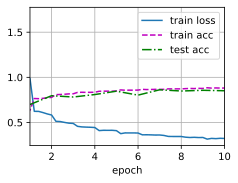

In [ ]:
lr, num_epochs = 0.1, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())